Because we have low sample size, a linear model with high bias and low variance will minimize overfitting when predicting OGTT glucose AUC.

Linear models are also good because they have robust tools for regularization to find a set of features that best predict OGTT. 

Using L1 regularization yields a model that tends to use SM 37:1 exclusively, and the weight for all other features is super low. 

Using L2 regularization just upweights all 200 TG-like features, and shrinks the coefficient for every other feature
    - This makes sense because TGs are very robust indicators of diabetes 
    
So either method by itself doesn't make a particularly useful model. 


Some options:
1. L1 regularization, except remove the top performing feature and then re-run model without it to find the next best. 

2. L2 regularization without TGs

3. Elastic net with custom tuning 

It's also worth showing the extent of the multi-colinearity to justify why we need to regularize in our quest for data-driven feature importance
Options: 
1. Show a clustered heatmap of pearson correlation
2. Calculate the variance inflation factor for each identified feature against all others 
    - Plot the V.I.F. for each feature in a stem plot
    - https://en.wikipedia.org/wiki/Variance_inflation_factor 
    - https://stats.stackexchange.com/questions/95082/pls-regression-and-collinearity

In [154]:
from collections import defaultdict
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['axes.unicode_minus'] = False  # https://stackoverflow.com/questions/43102564/matplotlib-negative-numbers-on-tick-labels-displayed-as-boxes
plt.style.use('seaborn-ticks')  # 'seaborn-ticks', 'seaborn-white', 'seaborn'

import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))  # Add the src directory to path 
from src.utils import tight_bbox
from src.plots import plot_quant_vs_ogtt
import seaborn as sns
import dateutil

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, LinearRegression, RidgeCV, Lasso, Ridge, ElasticNet
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import (
    cross_val_score, cross_val_predict, cross_validate,
    RepeatedKFold, RepeatedStratifiedKFold, 
    StratifiedGroupKFold, GroupKFold, StratifiedKFold,
    train_test_split, 
    GridSearchCV,
    LeaveOneGroupOut,)
import sklearn
print(sklearn.__version__)

from statsmodels.stats.outliers_influence import variance_inflation_factor

1.0.2


In [36]:
colors = json.load(open(r'..\data\metadata\color_schemes.json'))
colors['Non-fasted'] = colors['RBG']
colors['Fasted'] = colors['FBG']
compound_superclasses = json.load(open('../data/metadata/compound_superclasses.json', 'r'))
    
data = pd.read_csv(r'../data/processed/combined_metabolites_data_with_model_params.csv').set_index('i')
data_cols = data.filter(regex='_FBG|_RBG').columns
fbg_cols = data.filter(regex='_FBG').columns
rbg_cols = data.filter(regex='_RBG').columns

ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

## We only care about Fed data, so drop Fasted 

In [37]:
fg = fg.loc[fg['bg_type'] == 'RBG']
data_cols = data.filter(regex='_RBG').columns

In [247]:
X = data[data_cols].T
X_scaled = pd.DataFrame(StandardScaler().fit_transform(data[data_cols].T), index=data_cols, columns=data.index)
X_id = X_scaled.loc[:, data.loc[data['ID'] != 'Unidentified'].index]
X_id = X_id.drop(['m_104', 'm_68', 'm_135', 'm_127'], axis=1)
y_ogtt = fg.loc[~fg['validation'], 'ogtt']

i
m_2      2.631678e+07
m_3      6.261467e+07
m_4      5.202953e+07
m_5      9.008059e+07
m_6      1.818373e+07
             ...     
l_905    6.666641e+07
l_907    1.107396e+08
l_908    7.268917e+07
l_910    2.066025e+07
l_912    8.297334e+07
Name: vif, Length: 440, dtype: float64

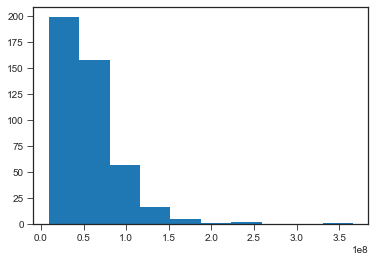

In [9]:
vifs = []
for idx in range(X_id.shape[1]):
    feature = X_id.columns[idx]
    vifs.append(variance_inflation_factor(X_id, idx))
plt.hist(vifs)

data_ids = data.loc[data['ID'] != 'Unidentified'].copy()
data_ids['vif'] = vifs
data_ids['vif'] 

### Distribution of variance inflation factors (VIF) for each identified feature against all other identified features
### Typically a VIF > 10 indicates strong co-linearity 
#### These values are all above 2e7 so biiiiig co-linearity 

This is another way of showing what a clustermap of Pearson correlation will show, that we have huge multi-colinearity


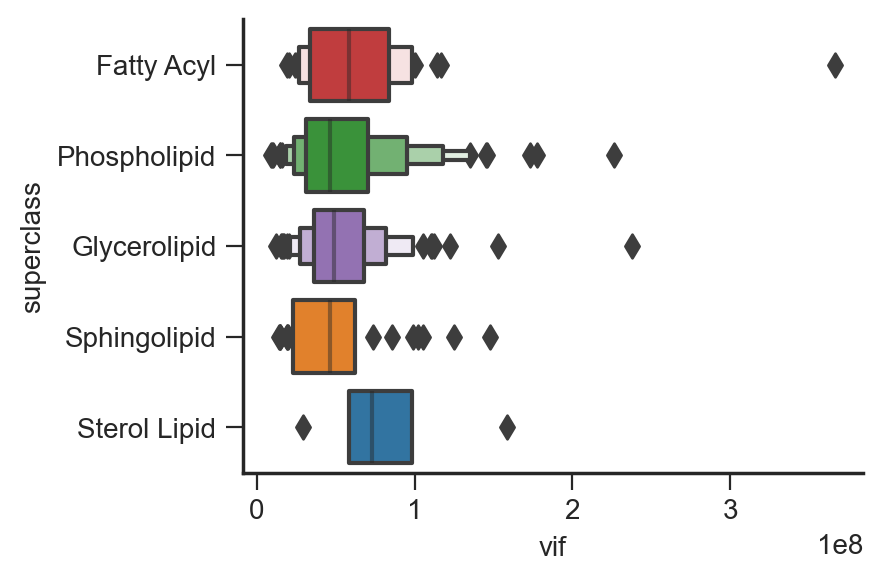

In [10]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=200)
sns.boxenplot(
    data=data_ids.loc[data_ids['Type'] == 'lipid'], x='vif', y='superclass', ax=ax, palette=colors,
    orient='h')
# ax.legend(loc=(1, 0))
sns.despine()

## Clustermap showing strong co-linearity of features, same idea as the distribution of VIFs above

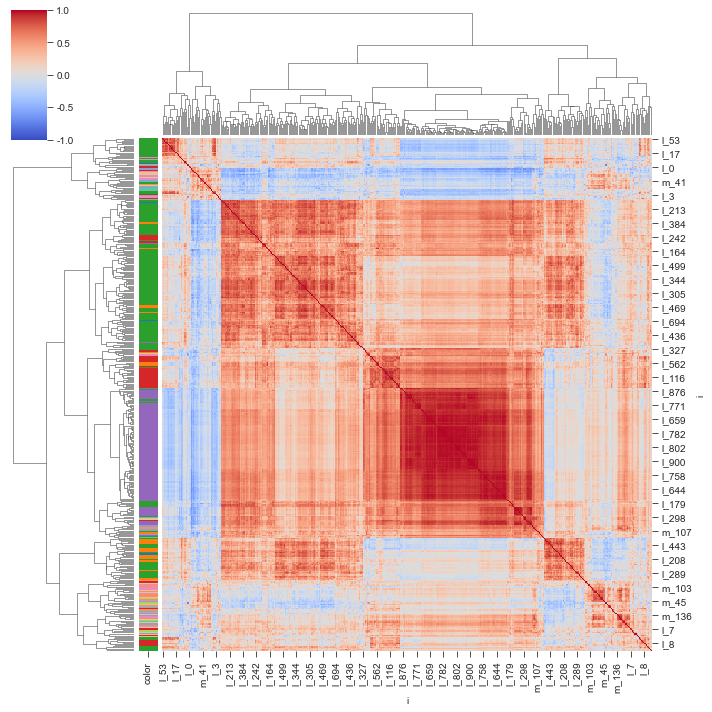

In [11]:
superclass_sorted = data_ids.sort_values(['Type', 'superclass']).index
hm_data = data_ids[data_cols].T.corr('pearson').loc[superclass_sorted, superclass_sorted]
data_ids['color'] = data_ids['superclass'].map(colors)
sns.clustermap(
    data=hm_data, 
#     row_cluster=False, col_cluster=False,
    method='complete', 
    metric='euclidean',
    cmap='coolwarm', vmin=-1, vmax=1,
    row_colors=data_ids['color'],
    
)

In [53]:
def linear_model_cv(model, X=X_id, display_features=40, n_splits=6, n_repeats=200):
    cross_val = cross_validate(
        estimator=model, 
        X=X, y=y_ogtt, 
        scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error'],
        cv=RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1),
        return_estimator=True,
        return_train_score=True,
        n_jobs=7,
    )
    rdf = pd.DataFrame(cross_val)
    try:
        raw_coefs = np.sum([estimator.coef_ for estimator in rdf['estimator']], axis=0)
    except:
        raw_coefs = np.sum([estimator.feature_importances_ for estimator in rdf['estimator']], axis=0)
    coefs = pd.DataFrame(raw_coefs, index=X.columns, columns=['coef'])
    coefs = coefs.div(coefs.abs().max())
    coefs = coefs.join(data['ID'])
    coefs = coefs.sort_values('coef', ascending=False, key=abs)
    q1 = round(rdf['test_r2'].quantile(0.25), 2)
    q3 = round(rdf['test_r2'].quantile(0.75), 2)
    mean = round(rdf['test_r2'].mean(), 2)
    median = round(rdf['test_r2'].median(), 2)
    print('R2 AVERAGE: ', mean)
    print('R2 MEDIAN: ', median)
    print('R2 IQR: ', q1, q3)
    print('MSE AVERAGE: ', f"{-1*rdf['test_neg_mean_squared_error'].mean():.2E}")
    plt.hist(raw_coefs / abs(raw_coefs).max(), bins=20)
    plt.figure()
    plt.hist(rdf['test_r2'], bins=20, range=(-1, 1))
    plt.axvline(median, zorder=10, color='black')
    display(coefs.iloc[0:display_features])
    return coefs, rdf

In [43]:
model = LinearRegression()
cross_val = cross_validate(
        estimator=model, 
        X=X, y=y_ogtt, 
        scoring=['r2', 'neg_mean_squared_error'],
        cv=RepeatedKFold(n_splits=6, n_repeats=10, random_state=1),
        return_estimator=True,
        return_train_score=True,
        n_jobs=7,
    )
rdf = pd.DataFrame(cross_val)
rdf

,fit_time,score_time,estimator,test_r2,train_r2,test_neg_mean_squared_error,train_neg_mean_squared_error
0,0.018997,0.022998,LinearRegression(),0.340621,1.0,-5.890419e+07,-1.636468e-20
1,0.021995,0.020999,LinearRegression(),0.751122,1.0,-4.066633e+07,-1.221898e-20
2,0.025995,0.021997,LinearRegression(),0.854484,1.0,-4.076655e+07,-1.692584e-20
3,0.024995,0.023000,LinearRegression(),0.708797,1.0,-4.668125e+07,-6.962611e-21
4,0.022999,0.022997,LinearRegression(),0.762719,1.0,-4.549793e+07,-7.031962e-21
5,0.030997,0.021998,LinearRegression(),0.425020,1.0,-3.995426e+07,-4.855616e-21
6,0.025997,0.023000,LinearRegression(),0.862595,1.0,-2.046561e+07,-8.889611e-21
7,0.022000,0.026999,LinearRegression(),0.625614,1.0,-2.932498e+07,-1.126077e-20
8,0.024999,0.022998,LinearRegression(),0.820401,1.0,-2.730377e+07,-5.621122e-21
9,0.022998,0.022999,LinearRegression(),0.848732,1.0,-2.554004e+07,-3.596184e-21


## Use OLS as benchmark for performance

R2 AVERAGE:  0.59
R2 MEDIAN:  0.79
R2 IQR:  0.53 0.84
MSE AVERAGE:  3.79E+07


,coef,ID
i,,
m_104,-1.000000,Ascorbic acid 2-sulfate
l_134,-0.997912,FA 18:0
l_844,-0.908001,CE 18:1
m_68,0.777225,Hexose sugar
l_431,-0.769386,Plasmanyl-PC O-32:1
m_127,-0.742377,4-Hydroxybenzaldehyde
l_186,-0.710926,PC 38:7
l_9,-0.708971,AC 14:1
l_164,0.707186,PC 36:3


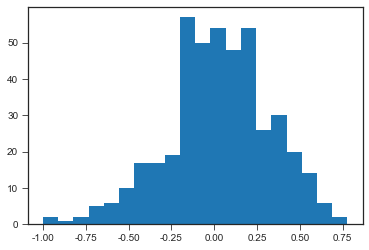

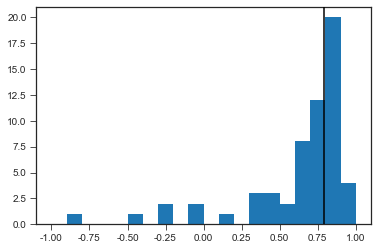

In [44]:
ols = LinearRegression()
ols_coefs, ols_rdf = linear_model_cv(ols, n_repeats=10)

## L1 regression
# Conclusion:
Using only identified features in the model:
1. higher values of alpha (regularization parameter) increase shrinkage and choose fewer metabolites
    - high alpha leads to more lipids, fewer metabolites, and picks out the questionable ID metabolites
    - R2 and MSE seem to be best between 10 and 100 after casual spot-checking
2. lower alpha leads to more metabolites and fewer lipids
    - picks out metabolites that are confident IDs and commonly found in plasma
    - Has lower R2 and higher MSE 
3. selecting alpha in [0.1, 1, 10, 100, 1000] shows these differences
4. alpha=35 gives approximately 30 features with non-zero coefficients
5. alpha=10000 gives glucose as the best metabolite (!) but R2 average = -0.22 and MSE is order of magnitude worse

R2 AVERAGE:  0.21
R2 MEDIAN:  0.49
R2 IQR:  0.21 0.68
MSE AVERAGE:  7.15E+07


,coef,ID
i,,
m_104,-1.000000,Ascorbic acid 2-sulfate
l_164,0.852998,PC 36:3
l_134,-0.774117,FA 18:0
l_569,0.649830,TG 20:5_22:6_22:6
m_68,0.543306,Hexose sugar
l_431,-0.532652,Plasmanyl-PC O-32:1
m_128,0.516858,4-Guanidinobutyric acid
l_844,-0.505898,CE 18:1
m_135,-0.482207,3-Indoxyl sulphate


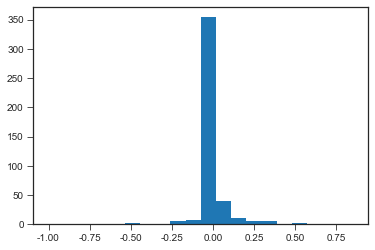

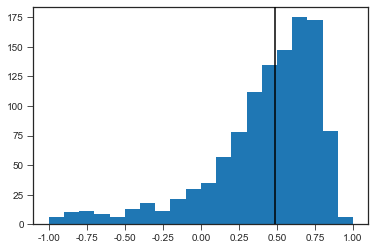

In [294]:
lasso = Lasso(alpha=30, tol=1e-3)
linear_model_cv(lasso)

## L2 regression used to pick out only TGs as top features
# Conclusion

2. alpha around 1000 - 10000 leads to selecting mostly TGs and histogram of coefficient distributions skews toward positive coefs
2. alpha around 100 returns to showing more features with negative coefs (i.e. more metabs)
3. alpha around 10 shows a balanced distribution of coefs around 0
4. Overall, R2 values are much better than L1 across the board 

R2 AVERAGE:  0.49
R2 MEDIAN:  0.71
R2 IQR:  0.53 0.81
MSE AVERAGE:  4.26E+07


,coef,ID
i,,
m_104,-1.000000,Ascorbic acid 2-sulfate
l_844,-0.948387,CE 18:1
l_134,-0.823093,FA 18:0
l_186,-0.788644,PC 38:7
l_431,-0.756879,Plasmanyl-PC O-32:1
m_68,0.742531,Hexose sugar
m_135,-0.735577,3-Indoxyl sulphate
l_569,0.719903,TG 20:5_22:6_22:6
m_34,-0.694317,"N6,N6,N6-Trimethyl-L-lysine"


(           coef                       ID
 i                                       
 m_104 -1.000000  Ascorbic acid 2-sulfate
 l_844 -0.948387                  CE 18:1
 l_134 -0.823093                  FA 18:0
 l_186 -0.788644                  PC 38:7
 l_431 -0.756879      Plasmanyl-PC O-32:1
 ...         ...                      ...
 l_754  0.007575                  TG 49:2
 l_699  0.006559        TG 15:0_18:2_18:2
 l_122 -0.004663                  FA 20:2
 l_372 -0.002077             PE 18:0_22:6
 l_727 -0.001624                  TG 54:5
 
 [440 rows x 2 columns],
       fit_time  score_time         estimator   test_r2  train_r2  \
 0     0.005997    0.008997  Ridge(alpha=100)  0.729749  0.972456   
 1     0.006001    0.006002  Ridge(alpha=100)  0.800911  0.968765   
 2     0.009995    0.010000  Ridge(alpha=100)  0.816153  0.966121   
 3     0.009997    0.010000  Ridge(alpha=100)  0.493302  0.971642   
 4     0.010996    0.009999  Ridge(alpha=100)  0.788013  0.970442   
 ...        .

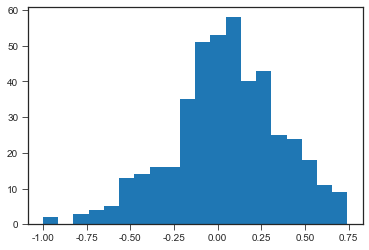

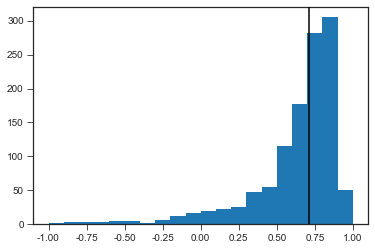

In [244]:
ridge = Ridge(alpha=100)
linear_model_cv(ridge)

## Compare to Elastic net 

# Conclusion
1. OLS is best performing regressor 
    - This is because of the rule that addition of a new feature can never reduce R2, the boost in R2 will always be 0 or positive
    - Median OLS R2 is about 0.75
    - The entire model is overfitting to train data given that p >> n
    - Can we achieve similar performance with just a subset of metabolites? 
1. L1 regression by itself has a best median R2 of about 0.55. 
    - L1 coefficients are show significant shrinkage above alpha=10
2. L2 has median R2 similar to OLS 
    - L2 has coefficient distribution that is approximately similar to OLS
    - Very high regularization 
3. Elastic net with a very high L1 ratio (0.999) significantly shrinks coefficients, but not at cost of median R2
    - Elastic net is the ideal balance of shrinkage while maintaining high R2 in test set
    
# `ElasticNet(alpha=500, l1_ratio=0.999)` gives the top 10 list I've been using lately

R2 AVERAGE:  0.41
R2 MEDIAN:  0.63
R2 IQR:  0.45 0.74
MSE AVERAGE:  5.29E+07


,coef,ID
i,,
l_844,-1.000000,CE 18:1
l_186,-0.834275,PC 38:7
l_505,0.658214,Plasmanyl-PC O-20:0_20:4
l_134,-0.637437,FA 18:0
l_164,0.606117,PC 36:3
m_128,0.575974,4-Guanidinobutyric acid
l_569,0.575844,TG 20:5_22:6_22:6
l_582,0.545499,TG 22:6_22:6_22:6
l_435,0.544138,SM d37:1


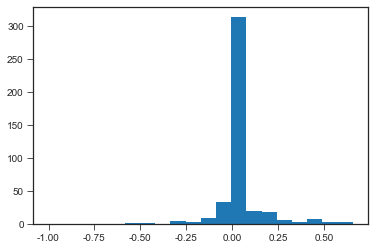

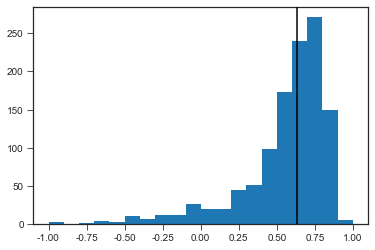

In [243]:
en = ElasticNet(alpha=500, l1_ratio=0.999)  # l1_ratio = 1 = all L1
en_coefs, en_rdf = linear_model_cv(en, X=X_id)

# Create a loadings plot of the top features from elastic net regression

In [108]:
df = en_coefs.loc[en_coefs['coef'] > 0.01]
df = df.join(data[['molec_class', 'superclass', 'Type']])
# re-normalize (because an Unidentified feature had the highest coefficient)
df['coef'] = df['coef'] / df['coef'].max()
df['i'] = df.index
df['color'] = df['superclass'].map(colors)
df['rank'] = df['coef'].rank(ascending=False)

mdf = df.loc[df['Type'] == 'metabolite']
ldf = df.loc[df['Type'] == 'lipid']

df

,coef,ID,molec_class,superclass,Type,i,color,rank
i,,,,,,,,
l_505,1.000000,Plasmanyl-PC O-20:0_20:4,Plasmanyl-PC,Phospholipid,lipid,l_505,"[0.17254901960784313, 0.6274509803921569, 0.17...",1.0
l_164,0.920851,PC 36:3,PC,Phospholipid,lipid,l_164,"[0.17254901960784313, 0.6274509803921569, 0.17...",2.0
m_128,0.875056,4-Guanidinobutyric acid,Organic acid,Organic acid,metabolite,m_128,"[0.8980392156862744, 0.7686274509803921, 0.580...",3.0
l_569,0.874858,TG 20:5_22:6_22:6,TG,Glycerolipid,lipid,l_569,"[0.5803921568627451, 0.403921568627451, 0.7411...",4.0
l_582,0.828757,TG 22:6_22:6_22:6,TG,Glycerolipid,lipid,l_582,"[0.5803921568627451, 0.403921568627451, 0.7411...",5.0
...,...,...,...,...,...,...,...,...
m_54,0.019980,Leucine,Amino acid,Amino acid,metabolite,m_54,"[0.9882352941176471, 0.5529411764705883, 0.384...",96.0
l_175,0.019109,PC 42:10,PC,Phospholipid,lipid,l_175,"[0.17254901960784313, 0.6274509803921569, 0.17...",97.0
l_260,0.017828,PC O-32:1,Plasmenyl-PC,Phospholipid,lipid,l_260,"[0.17254901960784313, 0.6274509803921569, 0.17...",98.0


findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, DejaVu Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, DejaVu Sans, Bitstream Vera Sans, sans-serif


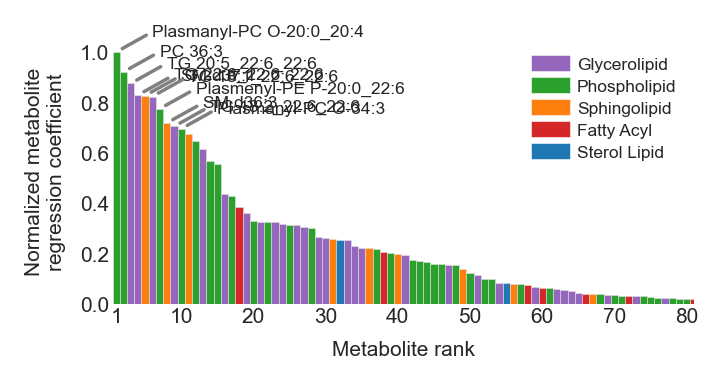

In [241]:
bdf = ldf

fig, ax = plt.subplots(dpi=250, figsize=(3, 1.4))
plt.bar(range(len(bdf)), bdf['coef'], color=bdf['color'], edgecolor='0.9', linewidth=0.15,
        width=1)
# sns.barplot(
#     x=list(range(len(bdf))), y=bdf['coef'], hue=bdf['superclass'], palette=colors, ax=ax,)
# for child in ax.get_children():
#     if isinstance(child, plt.Rectangle):
#         child.set_width(1)

ax.set_xticks(ticks=[0] + list(range(9, len(bdf), 10)), 
              labels=[1] + list(range(10, len(bdf), 10)), 
              fontsize=5)
ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1])
ax.tick_params(length=0, pad=1, labelsize=6)
# ax.
ax.set_xlabel('Metabolite rank', fontsize=6)
ax.set_ylabel('Normalized metabolite\nregression coefficient', fontsize=6)
ax.set_xlim(-0.5, 80)

# Add text labels to the top 10 metabolites
# offsets = [(3, 0.08), ()]
for counter, (i, row) in enumerate(bdf.iloc[:10].iterrows()):
    ax.annotate(text=row['ID'], xy=(counter, row['coef']), 
                xytext=(counter+5, row['coef']+0.05),
                arrowprops=dict(arrowstyle='-', relpos=(0, 0.5), lw=1, color='0.5'),
                bbox=dict(pad=-5, facecolor='none', edgecolor='none'),
                fontsize=5, annotation_clip=True, ha='left', va='bottom')

# Make legend
handles, labels = [], []
for cls in ['Glycerolipid', 'Phospholipid', 'Sphingolipid', 'Fatty Acyl', 'Sterol Lipid']:
    handles.append(Patch(color=colors[cls]))
    labels.append(cls)
ax.legend(handles, labels, 
          fontsize=5, borderpad=0.5, labelspacing=0.4, handlelength=2, handletextpad=0.5)
sns.despine(left=True, bottom=True)
# plt.savefig('../reports/figures/Figure6/lipid_coefficients_barplot.pdf', bbox_inches='tight', facecolor='white')

## Plot quant vs OGTT for the top elastic net features

,coef,ID
i,,
l_505,0.658214,Plasmanyl-PC O-20:0_20:4
l_164,0.606117,PC 36:3
m_128,0.575974,4-Guanidinobutyric acid
l_569,0.575844,TG 20:5_22:6_22:6
l_582,0.545499,TG 22:6_22:6_22:6
...,...,...
l_668,0.000007,TG 56:8
l_819,0.000005,TG 16:0_18:0_20:4
l_507,0.000004,SM d41:2


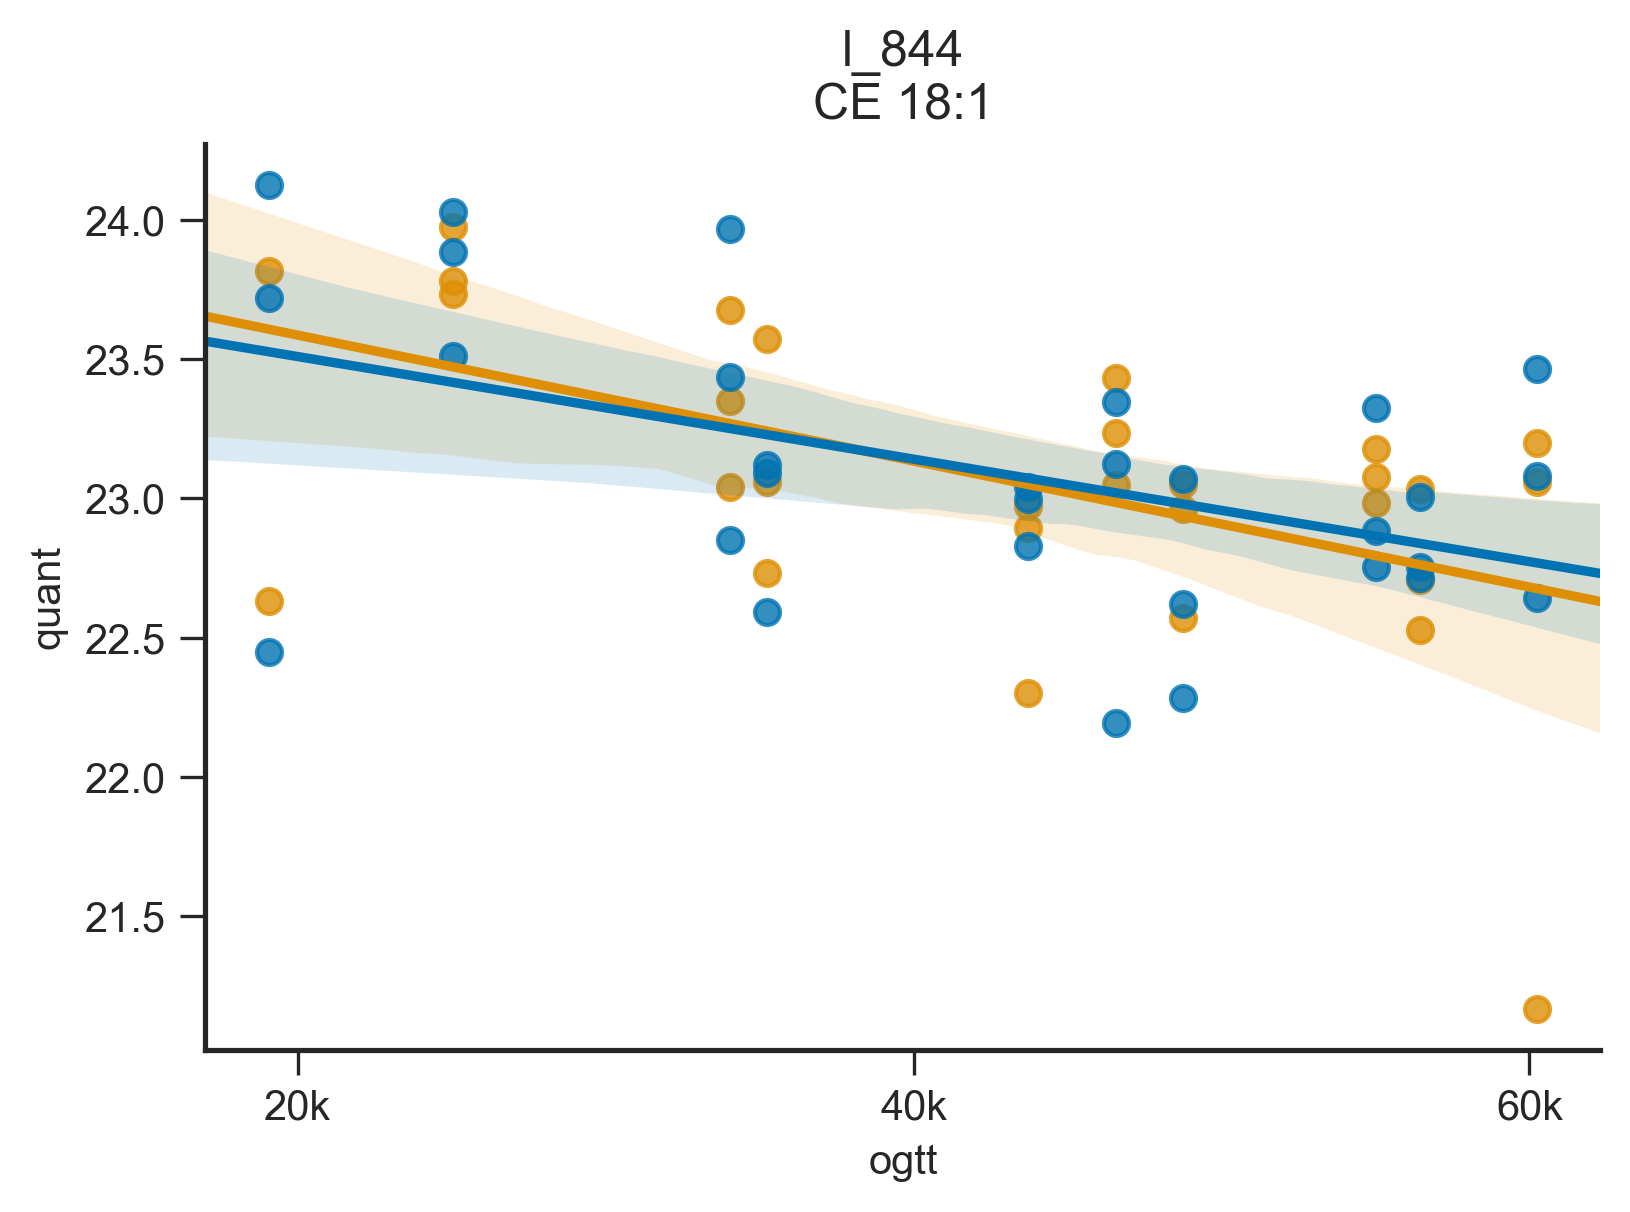

In [248]:
for i, row in en_coefs.iloc[:20].iterrows():
#     print(i, row['ID'])
    plot_quant_vs_ogtt(i)
    plt.gca().set_title(f"{i}\n{row.ID}")
    break
plt.gcf().set_dpi(300)

## Use the top ID'd features from elastic net to re-do OLS

R2 AVERAGE:  0.58
R2 MEDIAN:  0.75
R2 IQR:  0.55 0.85
MSE AVERAGE:  3.80E+07


,coef,ID
i,,
l_134,-1.000000,FA 18:0
m_128,0.742854,4-Guanidinobutyric acid
l_505,0.722043,Plasmanyl-PC O-20:0_20:4
l_435,0.641037,SM d37:1
l_844,-0.501549,CE 18:1
l_164,0.461499,PC 36:3
l_186,-0.409311,PC 38:7
l_582,0.370971,TG 22:6_22:6_22:6
l_648,0.076695,TG 18:1_22:6_22:6


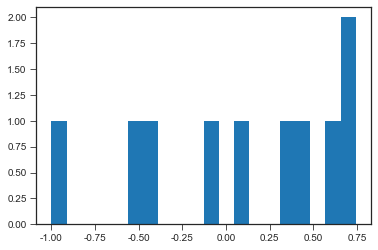

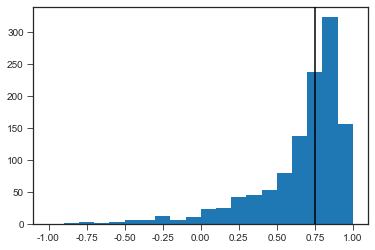

In [409]:
ols = LinearRegression()
top = en_coefs.iloc[:10].index
top_ols_coefs, top20_ols_rdf = linear_model_cv(model=ols, X=X.loc[:, top])

## Another method for feature selection that minimizes correlation between features:
Using the hierarchical clustering on method='complete' and metric='correlation', chop so that only 30 clusters remain
Then, in each cluster, take the feature with the highest p-value in the quant_vs_ogtt for fed data, and use that as the paragon for that cluster 
### However, this method is not needed because elastic net is sufficient

In [394]:
rdf['estimator'][0].feature_names_in_

array(['m_0', 'm_1', 'm_2', ..., 'l_914', 'l_915', 'l_916'], dtype=object)

# Re-do estimates with RF and PLSr

R2 AVERAGE:  0.74
R2 MEDIAN:  0.86
R2 IQR:  0.72 0.92
MSE AVERAGE:  2.20E+07


,coef,ID
i,,
l_435,1.000000,SM d37:1
l_505,0.872203,Plasmanyl-PC O-20:0_20:4
l_844,-0.821768,CE 18:1
l_134,-0.800855,FA 18:0
l_582,0.762828,TG 22:6_22:6_22:6
l_648,0.722479,TG 18:1_22:6_22:6
l_164,0.718934,PC 36:3
l_569,0.671353,TG 20:5_22:6_22:6
l_186,-0.660504,PC 38:7


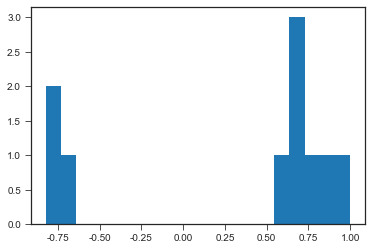

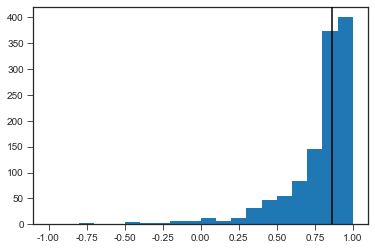

In [51]:
plsr = PLSRegression()
top = en_coefs.iloc[:10].index
plsr_coefs, plsr_rdf = linear_model_cv(model=plsr, X=X.loc[:, top])

R2 AVERAGE:  0.6
R2 MEDIAN:  0.73
R2 IQR:  0.52 0.82
MSE AVERAGE:  4.22E+07


,coef,ID
i,,
l_582,1.000000,TG 22:6_22:6_22:6
l_569,0.521724,TG 20:5_22:6_22:6
l_435,0.470346,SM d37:1
l_648,0.215656,TG 18:1_22:6_22:6
l_505,0.163256,Plasmanyl-PC O-20:0_20:4
l_186,0.134057,PC 38:7
m_128,0.089558,4-Guanidinobutyric acid
l_164,0.065455,PC 36:3
l_844,0.063931,CE 18:1


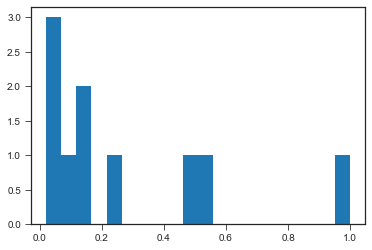

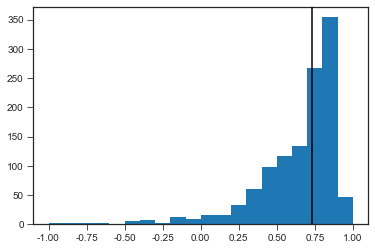

In [55]:
rfr = RandomForestRegressor()
top = en_coefs.iloc[:10].index
rfr_coefs, rfr_rdf = linear_model_cv(model=rfr, X=X.loc[:, top])

# Conclusion of using the top 10 features from elastic net:
1. Using the top 10 features improves the performance of PLS-R (!!!) 
2. Random forest also has a good result from it 

Index(['l_175', 'l_569', 'l_582', 'l_590', 'l_603', 'l_611', 'l_613', 'l_617',
       'l_623', 'l_632', 'l_635', 'l_644', 'l_648', 'l_652', 'l_663', 'l_665',
       'l_680', 'l_716'],
      dtype='object', name='i')

findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, DejaVu Sans, Bitstream Vera Sans, sans-serif


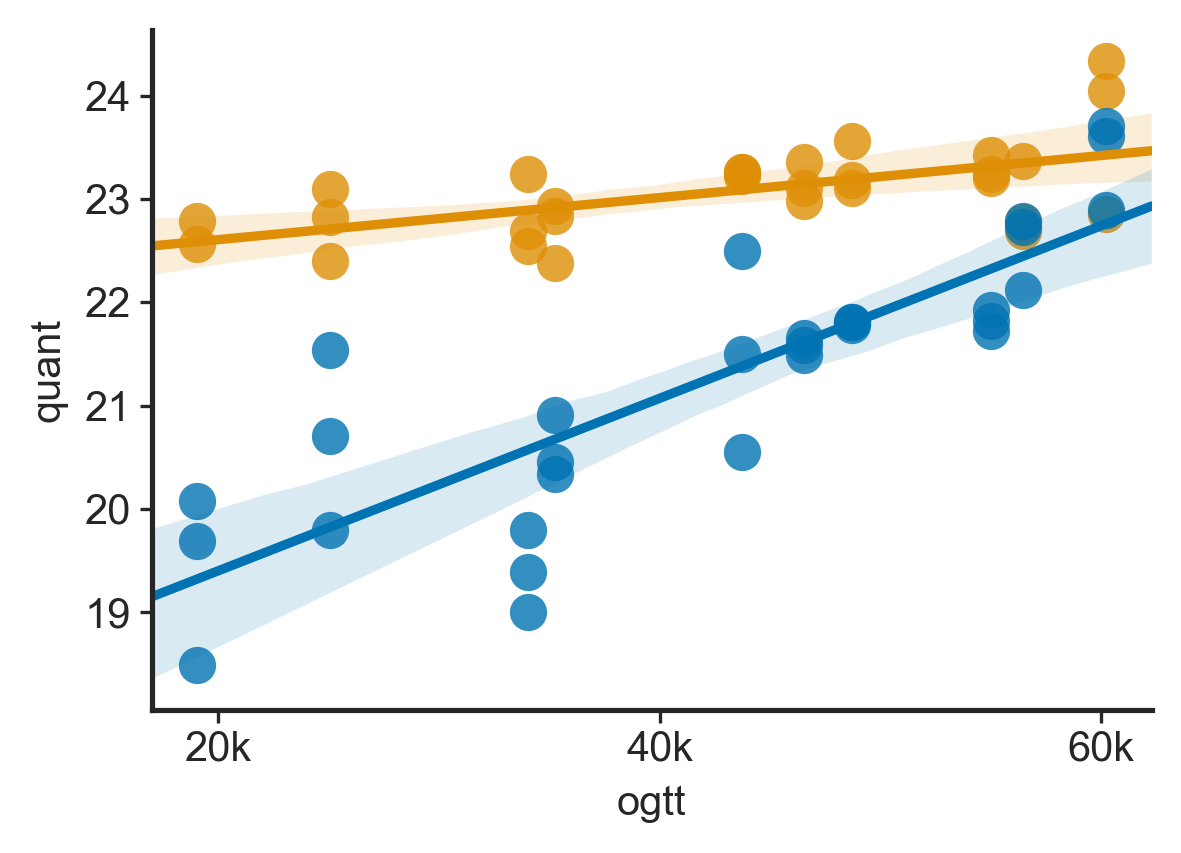

In [78]:
fig, ax = plt.subplots(dpi=300, figsize=(4.3, 3))
plot_quant_vs_ogtt(
    feature=data.loc[data['fa_unsat'] > 9].index, ax=ax,
    scatter_kws=dict(lw=0, s=80),
)
ax.tick_params(pad=2, length=3, labelsize=10)
# ax.set_yticks([19, 20, 21, 22, 23, 24])
plt.savefig('../reports/figures/Figure6/quant_vs_ogtt_TGs_10plus_unsats.pdf',
            bbox_inches='tight')